In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

<img src = 'https://images.manning.com/book/3/8e5d003-09e3-430e-a5a3-f42ee1cafb5f/Stevens-DLPy-HI.png' width = '500' height = '770'>

# 5. The mechanics of learning

Now, how is it exactly that a machine learns?

What are the mechanics fo this process-or, in words, what is the algorithm behind it?

With deep learning, this process works even when the input data and the desired output are far from each other:
    
when they come from different domains, like an image and a sentence describing it, as we saw in chapter 2.

## 5.1 A timeless lesson in modeling

Building models that allow us to explain input/output relationships dates back centuries at least. (Johannes Kepler)

In this book there is virtually no difference between saying that we'll fit the data or that we'll make an algorithm learn from data.

The prcoess always involves a function with a number of unknown parameters whose values are estimated from data: in short, a model

We're interested in models that are not engineered for solving a specific narrow task, but that can be automatically adapted to specialize

themselves for any one of many similar tasks using input and output pairs - in other words, general models trained on data relevant to the specific task at hand.

This chapter is about how to automate generic function-fitting.

## 5.2 Learning is just parameter estimation

<img src = "https://drek4537l1klr.cloudfront.net/stevens2/Figures/CH05_F02_Stevens2_GS.png">

We're now going to take a problem with a noisy dataset, build a model, and implement a learning algorithm for it.

When we finish the chpater, we will have covered many of the essential concepts that underlie training deep neural networks,

even if our motivating example is very simple and our model isn't actually a nerual network yet.

### 5.2.1 A hot problem

We'll build a dataset of reading and corresponding temperature values in our favorite units, choose a model,

adjust its weight iteratively until a measure of the error is low enough,

and finally be able to interpret the new readings in units we understand.

Let's try following the same process Kepler used. Along the way, we'll use a tool he never had available: PyTorch!
    
### 5.2.2 Gathering some data

We'll start by making a note of temperature data in good old Celsius and measurements from our new thermometer, and figure things out.

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

### 5.2.3 Visualizing the data

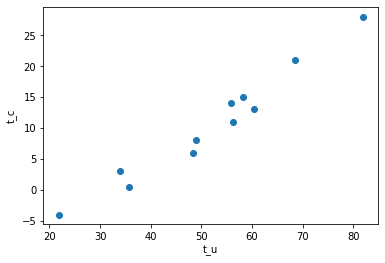

In [4]:
plt.scatter(t_u, t_c)
plt.xlabel('t_u')
plt.ylabel('t_c')
plt.show()

# 원래 책에서는 그림으로 삽입돼있지만 직접 그려봄

A quick plot of our data tells us that it's noisy, but we think thers's a pattern here.

We know a linear model is correct because the problem and data have been fabricated, but please bear with us.

It's a useful motivating example to build our understanding of what PyTorch is doing under the hood.

### 5.2.4 Choosing a linera model as a first try

In the absence of further knowledge, we assume the simplest possible model for converting between the two sets of meausrements,

just like Kepler might have done.

The two may be linearly realted - that is, multiplying t_u by factor and adding a constant, we may get the temperature in Celsius.

t_c = w * t_u + b

Is this a reasonable assumption?

Probably; we'll see how well the final model performs.

We chose to name w and b after weight and bias, two very common terms for linear scaling and the additive constant - we'll bump into those all the time.

## 5.3 Less loss is what we want

A loss function (or cost function) is a function that computes a single numerical value that the learning process will attempt to minimize.

In our case, that would be the difference between the predicted teperatures t_p output by our model and the actual measurements: t_p - t_c.
    
We need to make sure the loss function makes the loss positive.

We have a few choices, the most straightforward being |t_p - t_c| and (t_p - t_c)^2.

Since our model is linear, the loss as a function of w and b is also convex.

Cases where the loss is a convex function of the model parameters are usually great to deal with because

we can find a minimum very efficiently through specialized algorithms.

However, we will instead use less powerful but more generally applicable methods in this chapter.

We do so because for the deep neural networks we are ultimatley interested in, the loss i not a convex function of the inputs.

<img src = "https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5abssqdiff.png">

We notice that the square of the differences behaves more nicely around the minium:
    
the drivative of the error-squared loss with respect to t_p is zero when t_p equals t_c.

The absolut value, on the other hand, has an undefined derivative right where we'd like to converge.

We'll stick to the square of differences for the time being.

### 5.3.1 From problem back to PyTorch

Now we need to set the learning process in motion and feed it actual data.

Also, enough with math notation; lets' switch to PyTorch - after all, we came here for the fun.

In [5]:
def model(t_u, w, b):
    return w * t_u + b

We're expecting t_u, w, and b to be the input tensor, weight parameter, and bias parameter, respectively.

In our model, the parameters will be PyTorch scalars (aka zero dimensional tensors),

and the product operation will use broadcasting to yield the returend tensors.

In [6]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

This is a "mean square loss"

We can now initialize the parameters, invoke the model,

In [7]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

and check the value of the loss:

In [8]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

We've finally reached the meat of the example: how do we estimate w and b such that the loss reaches a minimum?

We'll first work things out by hand and then learn how to use PyTroch's super-powers to solve the same problem in a more general, off-the-shelf way.

## *Broadcasting

In [9]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)

print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


## 5.4 Down along the graident

We'll optimize the loss function with respect to the parameters using the gradient descent algorithm.

Gradient descent is actually a very simple ide, and it scales up surprisingly well to large neural network models with millions of parameters.

<img src = "https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5knobs.png">

A person with knobs for w and b searches for the direction to turn the knobs that makes the loss decrease

### 5.4.1 Decreasing loss

The idea is to compute the rate of change of the loss with respect to each parameter,

and modify each parameter in the direction of decreasing loss.

In [10]:
delta = 0.1

loss_rate_of_change_w = \
(loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

This is saying that in the neighborhood of the current values of w and b, a unit increase in w

leads to some change in the loss.

If the change is negative, we need to decrease w.

We typically should scale the rate of change by a small factor.

This scaling facotr has many names; the one we use in machine learning is learning_rate:

In [11]:
learning_rate = 1e-2 # 0.01

w = w - learning_rate * loss_rate_of_change_w

We can do the same with b:

In [12]:
loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

This represents the basic parameter-update step for gradient descent.

### 5.4.2 Getting analytical

Computing the rate of change by using repeated evaluations of the model and loss in order to probe the behavior of

the loss function in the neighborhood of w and b doesn't scale well to models with many parameters.

Also, it is not always clear how large the neighborhood should be.

We chose delta equal to 0.1 in the previous section, but it all depends on the shape of the loss as a function of w and b.

If the loss changes too quickly compared to delta, we won't have a very good idea of in which direction the loss is decreasing the most.

What if we could make the neighborhood infinitesimally small?

<img src = "https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5analyticalvsdiscrete.png">

(Differences in the estimated directions for descent when evaluating them at discret locations versus analytically)

That's exactly what happens when we analytically take the derivative of the loss with repsect to a parameter.

#### COMPUTING THE DERIVATIVES

In [13]:
def dloss_fn(t_p, t_c):  # derivative of loss_fn. recall def loss_fn ~
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) # The division is from the derivative of mean
    return dsq_diffs

In [14]:
def dmodel_dw(t_u, w, b): # derivative of model. recall def model ~
    return t_u

In [15]:
def dmodel_db(t_u, w, b):
    return 1.0

#### DEFINING THE GRADIENT FUNCTION

In [16]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

<img src = "https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5grad.png">

### 5.4.3 Iterating to fit the model

We now have everything in place to optimize our parameters.

Starting from a tentative value for a parameter, we can iteratively apply updates to it for a fixed number of iteraions, or until w and b stop chaning.

#### THE TRAINING LOOP

Let's introduct another piece of terminology.

We call a training iteraion during which we update the parameters for all of our training samples an "epoch".

The complete training loop looks like this.

In [17]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        params = params - learning_rate * grad
        
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
        
    return params

Now, let's invoke our training loop.

In [18]:
training_loop(n_epochs= 100,
              learning_rate = 1e-2,
             params = torch.tensor([1.0, 0.0]),
             t_u = t_u,
             t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 5802484.500000
Epoch 3, Loss 19408029696.000000
Epoch 4, Loss 64915905708032.000000
Epoch 5, Loss 217130525461053440.000000
Epoch 6, Loss 726257583152928129024.000000
Epoch 7, Loss 2429183416467662896627712.000000
Epoch 8, Loss 8125122549611731432050262016.000000
Epoch 9, Loss 27176882120842590626938030653440.000000
Epoch 10, Loss 90901105189019073810297959556841472.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epoch 38, Loss nan
Epoch 39, Loss nan
Epoch 40, Loss nan
Epoch 41, Loss

tensor([nan, nan])

What happened? Our training process literally blew up, leading to losses becoming 'inf'.

This is a clear sign that params is receiving updates that are too large, and their values start oscillating back and forth as each update overshoots and the next overcorrects even more.

The optimization process is unstable: it diverges instead of converging to a minimum.
    
We want to see smaller and smaller updates to params, not larger, as shown in figure.

<img src = "https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5diverge.png">

(Top: Diverging optimization on a convex function (parabola-like) due to large steps.
Bottom: Converging optimization with small steps.)

How can we limit the magnitude of 'learning_rate * grad'?

We could simply choose a smaller 'learning_rate', and indeed, the learning rate is one of the things we typically change when training does not go as well as we would like.

Let's go with 1e-4 and see how it works out:

In [19]:
training_loop(n_epochs = 100,
             learning_rate = 1e-4,
             params = torch.tensor([1.0, 0.0]),
             t_u = t_u,
              t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 323.090515
Epoch 3, Loss 78.929634
Epoch 4, Loss 37.552845
Epoch 5, Loss 30.540283
Epoch 6, Loss 29.351154
Epoch 7, Loss 29.148884
Epoch 8, Loss 29.113848
Epoch 9, Loss 29.107145
Epoch 10, Loss 29.105247
Epoch 11, Loss 29.104168
Epoch 12, Loss 29.103222
Epoch 13, Loss 29.102295
Epoch 14, Loss 29.101379
Epoch 15, Loss 29.100466
Epoch 16, Loss 29.099548
Epoch 17, Loss 29.098631
Epoch 18, Loss 29.097717
Epoch 19, Loss 29.096796
Epoch 20, Loss 29.095881
Epoch 21, Loss 29.094959
Epoch 22, Loss 29.094049
Epoch 23, Loss 29.093134
Epoch 24, Loss 29.092216
Epoch 25, Loss 29.091301
Epoch 26, Loss 29.090385
Epoch 27, Loss 29.089464
Epoch 28, Loss 29.088551
Epoch 29, Loss 29.087635
Epoch 30, Loss 29.086714
Epoch 31, Loss 29.085804
Epoch 32, Loss 29.084888
Epoch 33, Loss 29.083967
Epoch 34, Loss 29.083057
Epoch 35, Loss 29.082142
Epoch 36, Loss 29.081221
Epoch 37, Loss 29.080309
Epoch 38, Loss 29.079390
Epoch 39, Loss 29.078474
Epoch 40, Loss 29.077562
Epoch 

tensor([ 0.2327, -0.0438])

The behavior is now stable.

But there's another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls.

We could obviate this issue by making 'learning_rate' adaptive: that is, change according to the magnitude of updates.
    
There are optimization schemes that do that, and we'll see one toward in section 5.5.2

# 5.4.4 Normalizing inputs

We can see that the first-epoch gradient for the weight is about 50 times larger than the gradient for the bias.

This means the weight and bias live in differently scaled spaces.

If this is the case, a learning rate that's large enough to meaningfully update one will be so large as to be unstable for the other;

and a rate that's appropriate for the other won't be large enough to meaningfully change the first.

That means we're not going to be able to update our parameters unless we change something about our formulation of the problem.

There's a simpler way to keep things in check: changing the inputs so that the gradients aren't quite so different.

We can make sure the range of the input doesn't get too far from the range of -1.0 to 1.0, roughly speaking

In our case, we can achieve something close enough to that by simply mulitplying t_u by 0.1:

In [20]:
t_un = 0.1 * t_u

We denote the normalized version of t_u by appending an n to the variable name.

At this point, we can run the training loop on our normalized input.

In [22]:
training_loop(n_epochs = 100,
             learning_rate = 1e-2,
             params = torch.tensor([1.0, 0.0]),
             t_u = t_un, # Update t_u to our new, rescaled t_un
             t_c = t_c)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

tensor([ 2.7553, -2.5162])

Even though we set our learning rate back to 1e-2, parameters don't blow up during iterative updates.

Two gradients are of similar magnitude, so using a single learning_rate for both parameters works just fine.

Let's run the loop for enough iterations to see the changes in params get small.

We'll change n_epochs to 5,000:

In [24]:
params = training_loop(n_epochs = 5000,
                      learning_rate = 1e-2,
                      params = torch.tensor([1.0, 0.0]),
                      t_u = t_un,
                      t_c = t_c,
                      )

params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

Epoch 388, Loss 10.146438
Epoch 389, Loss 10.121935
Epoch 390, Loss 10.097512
Epoch 391, Loss 10.073173
Epoch 392, Loss 10.048919
Epoch 393, Loss 10.024743
Epoch 394, Loss 10.000652
Epoch 395, Loss 9.976640
Epoch 396, Loss 9.952712
Epoch 397, Loss 9.928862
Epoch 398, Loss 9.905093
Epoch 399, Loss 9.881409
Epoch 400, Loss 9.857804
Epoch 401, Loss 9.834277
Epoch 402, Loss 9.810831
Epoch 403, Loss 9.787466
Epoch 404, Loss 9.764176
Epoch 405, Loss 9.740973
Epoch 406, Loss 9.717843
Epoch 407, Loss 9.694793
Epoch 408, Loss 9.671824
Epoch 409, Loss 9.648926
Epoch 410, Loss 9.626110
Epoch 411, Loss 9.603373
Epoch 412, Loss 9.580709
Epoch 413, Loss 9.558125
Epoch 414, Loss 9.535617
Epoch 415, Loss 9.513184
Epoch 416, Loss 9.490829
Epoch 417, Loss 9.468551
Epoch 418, Loss 9.446347
Epoch 419, Loss 9.424216
Epoch 420, Loss 9.402164
Epoch 421, Loss 9.380184
Epoch 422, Loss 9.358282
Epoch 423, Loss 9.336448
Epoch 424, Loss 9.314695
Epoch 425, Loss 9.293012
Epoch 426, Loss 9.271403
Epoch 427, Loss 9.

Epoch 742, Loss 5.093765
Epoch 743, Loss 5.086414
Epoch 744, Loss 5.079086
Epoch 745, Loss 5.071781
Epoch 746, Loss 5.064505
Epoch 747, Loss 5.057247
Epoch 748, Loss 5.050021
Epoch 749, Loss 5.042817
Epoch 750, Loss 5.035636
Epoch 751, Loss 5.028476
Epoch 752, Loss 5.021346
Epoch 753, Loss 5.014240
Epoch 754, Loss 5.007157
Epoch 755, Loss 5.000099
Epoch 756, Loss 4.993064
Epoch 757, Loss 4.986051
Epoch 758, Loss 4.979064
Epoch 759, Loss 4.972100
Epoch 760, Loss 4.965159
Epoch 761, Loss 4.958245
Epoch 762, Loss 4.951351
Epoch 763, Loss 4.944479
Epoch 764, Loss 4.937633
Epoch 765, Loss 4.930812
Epoch 766, Loss 4.924009
Epoch 767, Loss 4.917234
Epoch 768, Loss 4.910480
Epoch 769, Loss 4.903749
Epoch 770, Loss 4.897040
Epoch 771, Loss 4.890356
Epoch 772, Loss 4.883692
Epoch 773, Loss 4.877052
Epoch 774, Loss 4.870436
Epoch 775, Loss 4.863839
Epoch 776, Loss 4.857268
Epoch 777, Loss 4.850718
Epoch 778, Loss 4.844189
Epoch 779, Loss 4.837683
Epoch 780, Loss 4.831196
Epoch 781, Loss 4.824737


Epoch 1072, Loss 3.632902
Epoch 1073, Loss 3.630508
Epoch 1074, Loss 3.628119
Epoch 1075, Loss 3.625741
Epoch 1076, Loss 3.623374
Epoch 1077, Loss 3.621010
Epoch 1078, Loss 3.618659
Epoch 1079, Loss 3.616311
Epoch 1080, Loss 3.613973
Epoch 1081, Loss 3.611643
Epoch 1082, Loss 3.609321
Epoch 1083, Loss 3.607008
Epoch 1084, Loss 3.604701
Epoch 1085, Loss 3.602403
Epoch 1086, Loss 3.600114
Epoch 1087, Loss 3.597831
Epoch 1088, Loss 3.595553
Epoch 1089, Loss 3.593287
Epoch 1090, Loss 3.591030
Epoch 1091, Loss 3.588776
Epoch 1092, Loss 3.586534
Epoch 1093, Loss 3.584294
Epoch 1094, Loss 3.582067
Epoch 1095, Loss 3.579845
Epoch 1096, Loss 3.577631
Epoch 1097, Loss 3.575424
Epoch 1098, Loss 3.573225
Epoch 1099, Loss 3.571035
Epoch 1100, Loss 3.568848
Epoch 1101, Loss 3.566673
Epoch 1102, Loss 3.564506
Epoch 1103, Loss 3.562341
Epoch 1104, Loss 3.560185
Epoch 1105, Loss 3.558040
Epoch 1106, Loss 3.555901
Epoch 1107, Loss 3.553767
Epoch 1108, Loss 3.551641
Epoch 1109, Loss 3.549524
Epoch 1110, 

Epoch 1424, Loss 3.140712
Epoch 1425, Loss 3.139989
Epoch 1426, Loss 3.139271
Epoch 1427, Loss 3.138551
Epoch 1428, Loss 3.137835
Epoch 1429, Loss 3.137121
Epoch 1430, Loss 3.136409
Epoch 1431, Loss 3.135702
Epoch 1432, Loss 3.134994
Epoch 1433, Loss 3.134292
Epoch 1434, Loss 3.133590
Epoch 1435, Loss 3.132889
Epoch 1436, Loss 3.132194
Epoch 1437, Loss 3.131500
Epoch 1438, Loss 3.130810
Epoch 1439, Loss 3.130119
Epoch 1440, Loss 3.129432
Epoch 1441, Loss 3.128746
Epoch 1442, Loss 3.128064
Epoch 1443, Loss 3.127382
Epoch 1444, Loss 3.126705
Epoch 1445, Loss 3.126030
Epoch 1446, Loss 3.125356
Epoch 1447, Loss 3.124683
Epoch 1448, Loss 3.124016
Epoch 1449, Loss 3.123349
Epoch 1450, Loss 3.122686
Epoch 1451, Loss 3.122022
Epoch 1452, Loss 3.121362
Epoch 1453, Loss 3.120707
Epoch 1454, Loss 3.120049
Epoch 1455, Loss 3.119397
Epoch 1456, Loss 3.118746
Epoch 1457, Loss 3.118098
Epoch 1458, Loss 3.117451
Epoch 1459, Loss 3.116805
Epoch 1460, Loss 3.116164
Epoch 1461, Loss 3.115525
Epoch 1462, 

Epoch 1832, Loss 2.980856
Epoch 1833, Loss 2.980675
Epoch 1834, Loss 2.980495
Epoch 1835, Loss 2.980315
Epoch 1836, Loss 2.980137
Epoch 1837, Loss 2.979958
Epoch 1838, Loss 2.979782
Epoch 1839, Loss 2.979604
Epoch 1840, Loss 2.979428
Epoch 1841, Loss 2.979253
Epoch 1842, Loss 2.979078
Epoch 1843, Loss 2.978902
Epoch 1844, Loss 2.978729
Epoch 1845, Loss 2.978556
Epoch 1846, Loss 2.978382
Epoch 1847, Loss 2.978211
Epoch 1848, Loss 2.978039
Epoch 1849, Loss 2.977867
Epoch 1850, Loss 2.977696
Epoch 1851, Loss 2.977527
Epoch 1852, Loss 2.977357
Epoch 1853, Loss 2.977188
Epoch 1854, Loss 2.977021
Epoch 1855, Loss 2.976853
Epoch 1856, Loss 2.976687
Epoch 1857, Loss 2.976520
Epoch 1858, Loss 2.976354
Epoch 1859, Loss 2.976189
Epoch 1860, Loss 2.976023
Epoch 1861, Loss 2.975860
Epoch 1862, Loss 2.975697
Epoch 1863, Loss 2.975533
Epoch 1864, Loss 2.975369
Epoch 1865, Loss 2.975208
Epoch 1866, Loss 2.975046
Epoch 1867, Loss 2.974886
Epoch 1868, Loss 2.974725
Epoch 1869, Loss 2.974565
Epoch 1870, 

Epoch 2217, Loss 2.942014
Epoch 2218, Loss 2.941965
Epoch 2219, Loss 2.941918
Epoch 2220, Loss 2.941868
Epoch 2221, Loss 2.941821
Epoch 2222, Loss 2.941773
Epoch 2223, Loss 2.941724
Epoch 2224, Loss 2.941677
Epoch 2225, Loss 2.941629
Epoch 2226, Loss 2.941582
Epoch 2227, Loss 2.941534
Epoch 2228, Loss 2.941488
Epoch 2229, Loss 2.941440
Epoch 2230, Loss 2.941393
Epoch 2231, Loss 2.941346
Epoch 2232, Loss 2.941299
Epoch 2233, Loss 2.941253
Epoch 2234, Loss 2.941206
Epoch 2235, Loss 2.941163
Epoch 2236, Loss 2.941116
Epoch 2237, Loss 2.941070
Epoch 2238, Loss 2.941025
Epoch 2239, Loss 2.940979
Epoch 2240, Loss 2.940933
Epoch 2241, Loss 2.940890
Epoch 2242, Loss 2.940844
Epoch 2243, Loss 2.940798
Epoch 2244, Loss 2.940753
Epoch 2245, Loss 2.940711
Epoch 2246, Loss 2.940666
Epoch 2247, Loss 2.940621
Epoch 2248, Loss 2.940576
Epoch 2249, Loss 2.940533
Epoch 2250, Loss 2.940489
Epoch 2251, Loss 2.940446
Epoch 2252, Loss 2.940403
Epoch 2253, Loss 2.940358
Epoch 2254, Loss 2.940316
Epoch 2255, 

Epoch 2547, Loss 2.932324
Epoch 2548, Loss 2.932310
Epoch 2549, Loss 2.932293
Epoch 2550, Loss 2.932277
Epoch 2551, Loss 2.932261
Epoch 2552, Loss 2.932246
Epoch 2553, Loss 2.932229
Epoch 2554, Loss 2.932215
Epoch 2555, Loss 2.932198
Epoch 2556, Loss 2.932183
Epoch 2557, Loss 2.932167
Epoch 2558, Loss 2.932153
Epoch 2559, Loss 2.932137
Epoch 2560, Loss 2.932122
Epoch 2561, Loss 2.932107
Epoch 2562, Loss 2.932092
Epoch 2563, Loss 2.932076
Epoch 2564, Loss 2.932061
Epoch 2565, Loss 2.932047
Epoch 2566, Loss 2.932031
Epoch 2567, Loss 2.932017
Epoch 2568, Loss 2.932002
Epoch 2569, Loss 2.931986
Epoch 2570, Loss 2.931972
Epoch 2571, Loss 2.931957
Epoch 2572, Loss 2.931941
Epoch 2573, Loss 2.931929
Epoch 2574, Loss 2.931914
Epoch 2575, Loss 2.931900
Epoch 2576, Loss 2.931885
Epoch 2577, Loss 2.931870
Epoch 2578, Loss 2.931855
Epoch 2579, Loss 2.931842
Epoch 2580, Loss 2.931828
Epoch 2581, Loss 2.931813
Epoch 2582, Loss 2.931799
Epoch 2583, Loss 2.931786
Epoch 2584, Loss 2.931771
Epoch 2585, 

Epoch 2967, Loss 2.928767
Epoch 2968, Loss 2.928765
Epoch 2969, Loss 2.928761
Epoch 2970, Loss 2.928758
Epoch 2971, Loss 2.928752
Epoch 2972, Loss 2.928750
Epoch 2973, Loss 2.928745
Epoch 2974, Loss 2.928741
Epoch 2975, Loss 2.928737
Epoch 2976, Loss 2.928735
Epoch 2977, Loss 2.928730
Epoch 2978, Loss 2.928727
Epoch 2979, Loss 2.928723
Epoch 2980, Loss 2.928719
Epoch 2981, Loss 2.928716
Epoch 2982, Loss 2.928712
Epoch 2983, Loss 2.928708
Epoch 2984, Loss 2.928705
Epoch 2985, Loss 2.928700
Epoch 2986, Loss 2.928698
Epoch 2987, Loss 2.928695
Epoch 2988, Loss 2.928690
Epoch 2989, Loss 2.928687
Epoch 2990, Loss 2.928684
Epoch 2991, Loss 2.928679
Epoch 2992, Loss 2.928677
Epoch 2993, Loss 2.928673
Epoch 2994, Loss 2.928669
Epoch 2995, Loss 2.928666
Epoch 2996, Loss 2.928662
Epoch 2997, Loss 2.928660
Epoch 2998, Loss 2.928656
Epoch 2999, Loss 2.928651
Epoch 3000, Loss 2.928648
Epoch 3001, Loss 2.928646
Epoch 3002, Loss 2.928643
Epoch 3003, Loss 2.928638
Epoch 3004, Loss 2.928635
Epoch 3005, 

Epoch 3371, Loss 2.927928
Epoch 3372, Loss 2.927931
Epoch 3373, Loss 2.927929
Epoch 3374, Loss 2.927927
Epoch 3375, Loss 2.927926
Epoch 3376, Loss 2.927925
Epoch 3377, Loss 2.927924
Epoch 3378, Loss 2.927923
Epoch 3379, Loss 2.927924
Epoch 3380, Loss 2.927922
Epoch 3381, Loss 2.927922
Epoch 3382, Loss 2.927920
Epoch 3383, Loss 2.927918
Epoch 3384, Loss 2.927917
Epoch 3385, Loss 2.927917
Epoch 3386, Loss 2.927915
Epoch 3387, Loss 2.927915
Epoch 3388, Loss 2.927914
Epoch 3389, Loss 2.927913
Epoch 3390, Loss 2.927911
Epoch 3391, Loss 2.927913
Epoch 3392, Loss 2.927911
Epoch 3393, Loss 2.927910
Epoch 3394, Loss 2.927909
Epoch 3395, Loss 2.927908
Epoch 3396, Loss 2.927907
Epoch 3397, Loss 2.927906
Epoch 3398, Loss 2.927905
Epoch 3399, Loss 2.927905
Epoch 3400, Loss 2.927904
Epoch 3401, Loss 2.927902
Epoch 3402, Loss 2.927902
Epoch 3403, Loss 2.927902
Epoch 3404, Loss 2.927899
Epoch 3405, Loss 2.927899
Epoch 3406, Loss 2.927898
Epoch 3407, Loss 2.927899
Epoch 3408, Loss 2.927896
Epoch 3409, 

Epoch 3773, Loss 2.927720
Epoch 3774, Loss 2.927718
Epoch 3775, Loss 2.927718
Epoch 3776, Loss 2.927717
Epoch 3777, Loss 2.927718
Epoch 3778, Loss 2.927717
Epoch 3779, Loss 2.927717
Epoch 3780, Loss 2.927716
Epoch 3781, Loss 2.927716
Epoch 3782, Loss 2.927717
Epoch 3783, Loss 2.927717
Epoch 3784, Loss 2.927716
Epoch 3785, Loss 2.927715
Epoch 3786, Loss 2.927715
Epoch 3787, Loss 2.927715
Epoch 3788, Loss 2.927715
Epoch 3789, Loss 2.927715
Epoch 3790, Loss 2.927715
Epoch 3791, Loss 2.927714
Epoch 3792, Loss 2.927714
Epoch 3793, Loss 2.927714
Epoch 3794, Loss 2.927714
Epoch 3795, Loss 2.927713
Epoch 3796, Loss 2.927714
Epoch 3797, Loss 2.927713
Epoch 3798, Loss 2.927712
Epoch 3799, Loss 2.927712
Epoch 3800, Loss 2.927713
Epoch 3801, Loss 2.927711
Epoch 3802, Loss 2.927712
Epoch 3803, Loss 2.927712
Epoch 3804, Loss 2.927711
Epoch 3805, Loss 2.927712
Epoch 3806, Loss 2.927711
Epoch 3807, Loss 2.927711
Epoch 3808, Loss 2.927711
Epoch 3809, Loss 2.927709
Epoch 3810, Loss 2.927710
Epoch 3811, 

Epoch 4125, Loss 2.927670
Epoch 4126, Loss 2.927666
Epoch 4127, Loss 2.927669
Epoch 4128, Loss 2.927668
Epoch 4129, Loss 2.927669
Epoch 4130, Loss 2.927667
Epoch 4131, Loss 2.927667
Epoch 4132, Loss 2.927668
Epoch 4133, Loss 2.927667
Epoch 4134, Loss 2.927667
Epoch 4135, Loss 2.927666
Epoch 4136, Loss 2.927666
Epoch 4137, Loss 2.927669
Epoch 4138, Loss 2.927666
Epoch 4139, Loss 2.927668
Epoch 4140, Loss 2.927666
Epoch 4141, Loss 2.927667
Epoch 4142, Loss 2.927667
Epoch 4143, Loss 2.927666
Epoch 4144, Loss 2.927667
Epoch 4145, Loss 2.927666
Epoch 4146, Loss 2.927667
Epoch 4147, Loss 2.927667
Epoch 4148, Loss 2.927667
Epoch 4149, Loss 2.927667
Epoch 4150, Loss 2.927665
Epoch 4151, Loss 2.927666
Epoch 4152, Loss 2.927666
Epoch 4153, Loss 2.927666
Epoch 4154, Loss 2.927666
Epoch 4155, Loss 2.927666
Epoch 4156, Loss 2.927666
Epoch 4157, Loss 2.927666
Epoch 4158, Loss 2.927665
Epoch 4159, Loss 2.927666
Epoch 4160, Loss 2.927665
Epoch 4161, Loss 2.927664
Epoch 4162, Loss 2.927666
Epoch 4163, 

Epoch 4601, Loss 2.927651
Epoch 4602, Loss 2.927650
Epoch 4603, Loss 2.927650
Epoch 4604, Loss 2.927650
Epoch 4605, Loss 2.927651
Epoch 4606, Loss 2.927651
Epoch 4607, Loss 2.927651
Epoch 4608, Loss 2.927651
Epoch 4609, Loss 2.927651
Epoch 4610, Loss 2.927649
Epoch 4611, Loss 2.927649
Epoch 4612, Loss 2.927650
Epoch 4613, Loss 2.927649
Epoch 4614, Loss 2.927649
Epoch 4615, Loss 2.927650
Epoch 4616, Loss 2.927650
Epoch 4617, Loss 2.927650
Epoch 4618, Loss 2.927650
Epoch 4619, Loss 2.927651
Epoch 4620, Loss 2.927650
Epoch 4621, Loss 2.927650
Epoch 4622, Loss 2.927651
Epoch 4623, Loss 2.927650
Epoch 4624, Loss 2.927651
Epoch 4625, Loss 2.927651
Epoch 4626, Loss 2.927651
Epoch 4627, Loss 2.927651
Epoch 4628, Loss 2.927650
Epoch 4629, Loss 2.927651
Epoch 4630, Loss 2.927651
Epoch 4631, Loss 2.927650
Epoch 4632, Loss 2.927651
Epoch 4633, Loss 2.927651
Epoch 4634, Loss 2.927650
Epoch 4635, Loss 2.927650
Epoch 4636, Loss 2.927650
Epoch 4637, Loss 2.927649
Epoch 4638, Loss 2.927650
Epoch 4639, 

Epoch 4936, Loss 2.927646
Epoch 4937, Loss 2.927648
Epoch 4938, Loss 2.927646
Epoch 4939, Loss 2.927647
Epoch 4940, Loss 2.927646
Epoch 4941, Loss 2.927649
Epoch 4942, Loss 2.927648
Epoch 4943, Loss 2.927646
Epoch 4944, Loss 2.927649
Epoch 4945, Loss 2.927646
Epoch 4946, Loss 2.927647
Epoch 4947, Loss 2.927648
Epoch 4948, Loss 2.927649
Epoch 4949, Loss 2.927646
Epoch 4950, Loss 2.927648
Epoch 4951, Loss 2.927646
Epoch 4952, Loss 2.927646
Epoch 4953, Loss 2.927648
Epoch 4954, Loss 2.927647
Epoch 4955, Loss 2.927647
Epoch 4956, Loss 2.927647
Epoch 4957, Loss 2.927648
Epoch 4958, Loss 2.927646
Epoch 4959, Loss 2.927648
Epoch 4960, Loss 2.927647
Epoch 4961, Loss 2.927648
Epoch 4962, Loss 2.927646
Epoch 4963, Loss 2.927648
Epoch 4964, Loss 2.927647
Epoch 4965, Loss 2.927647
Epoch 4966, Loss 2.927648
Epoch 4967, Loss 2.927646
Epoch 4968, Loss 2.927647
Epoch 4969, Loss 2.927647
Epoch 4970, Loss 2.927648
Epoch 4971, Loss 2.927648
Epoch 4972, Loss 2.927647
Epoch 4973, Loss 2.927648
Epoch 4974, 

tensor([  5.3671, -17.3012])

Good: our loss decreases while we change parameters along the direction of gradient descent.
    
It doesn't go exactly to zero; this could mean there aren't enough iterations to converget to zero, or that the data points don't sit exactly on a line.

As we anticipated, our measurements were not perfectly accurate, or there was noise involved in the reading.

But look: the values for w and b look an awful lot like the numbers we need to use to convert Celsius to Fahrenheit.
    
The exact values would be w = 5.5556 and b = - 17.7778.

### 5.4.5 Visualizing

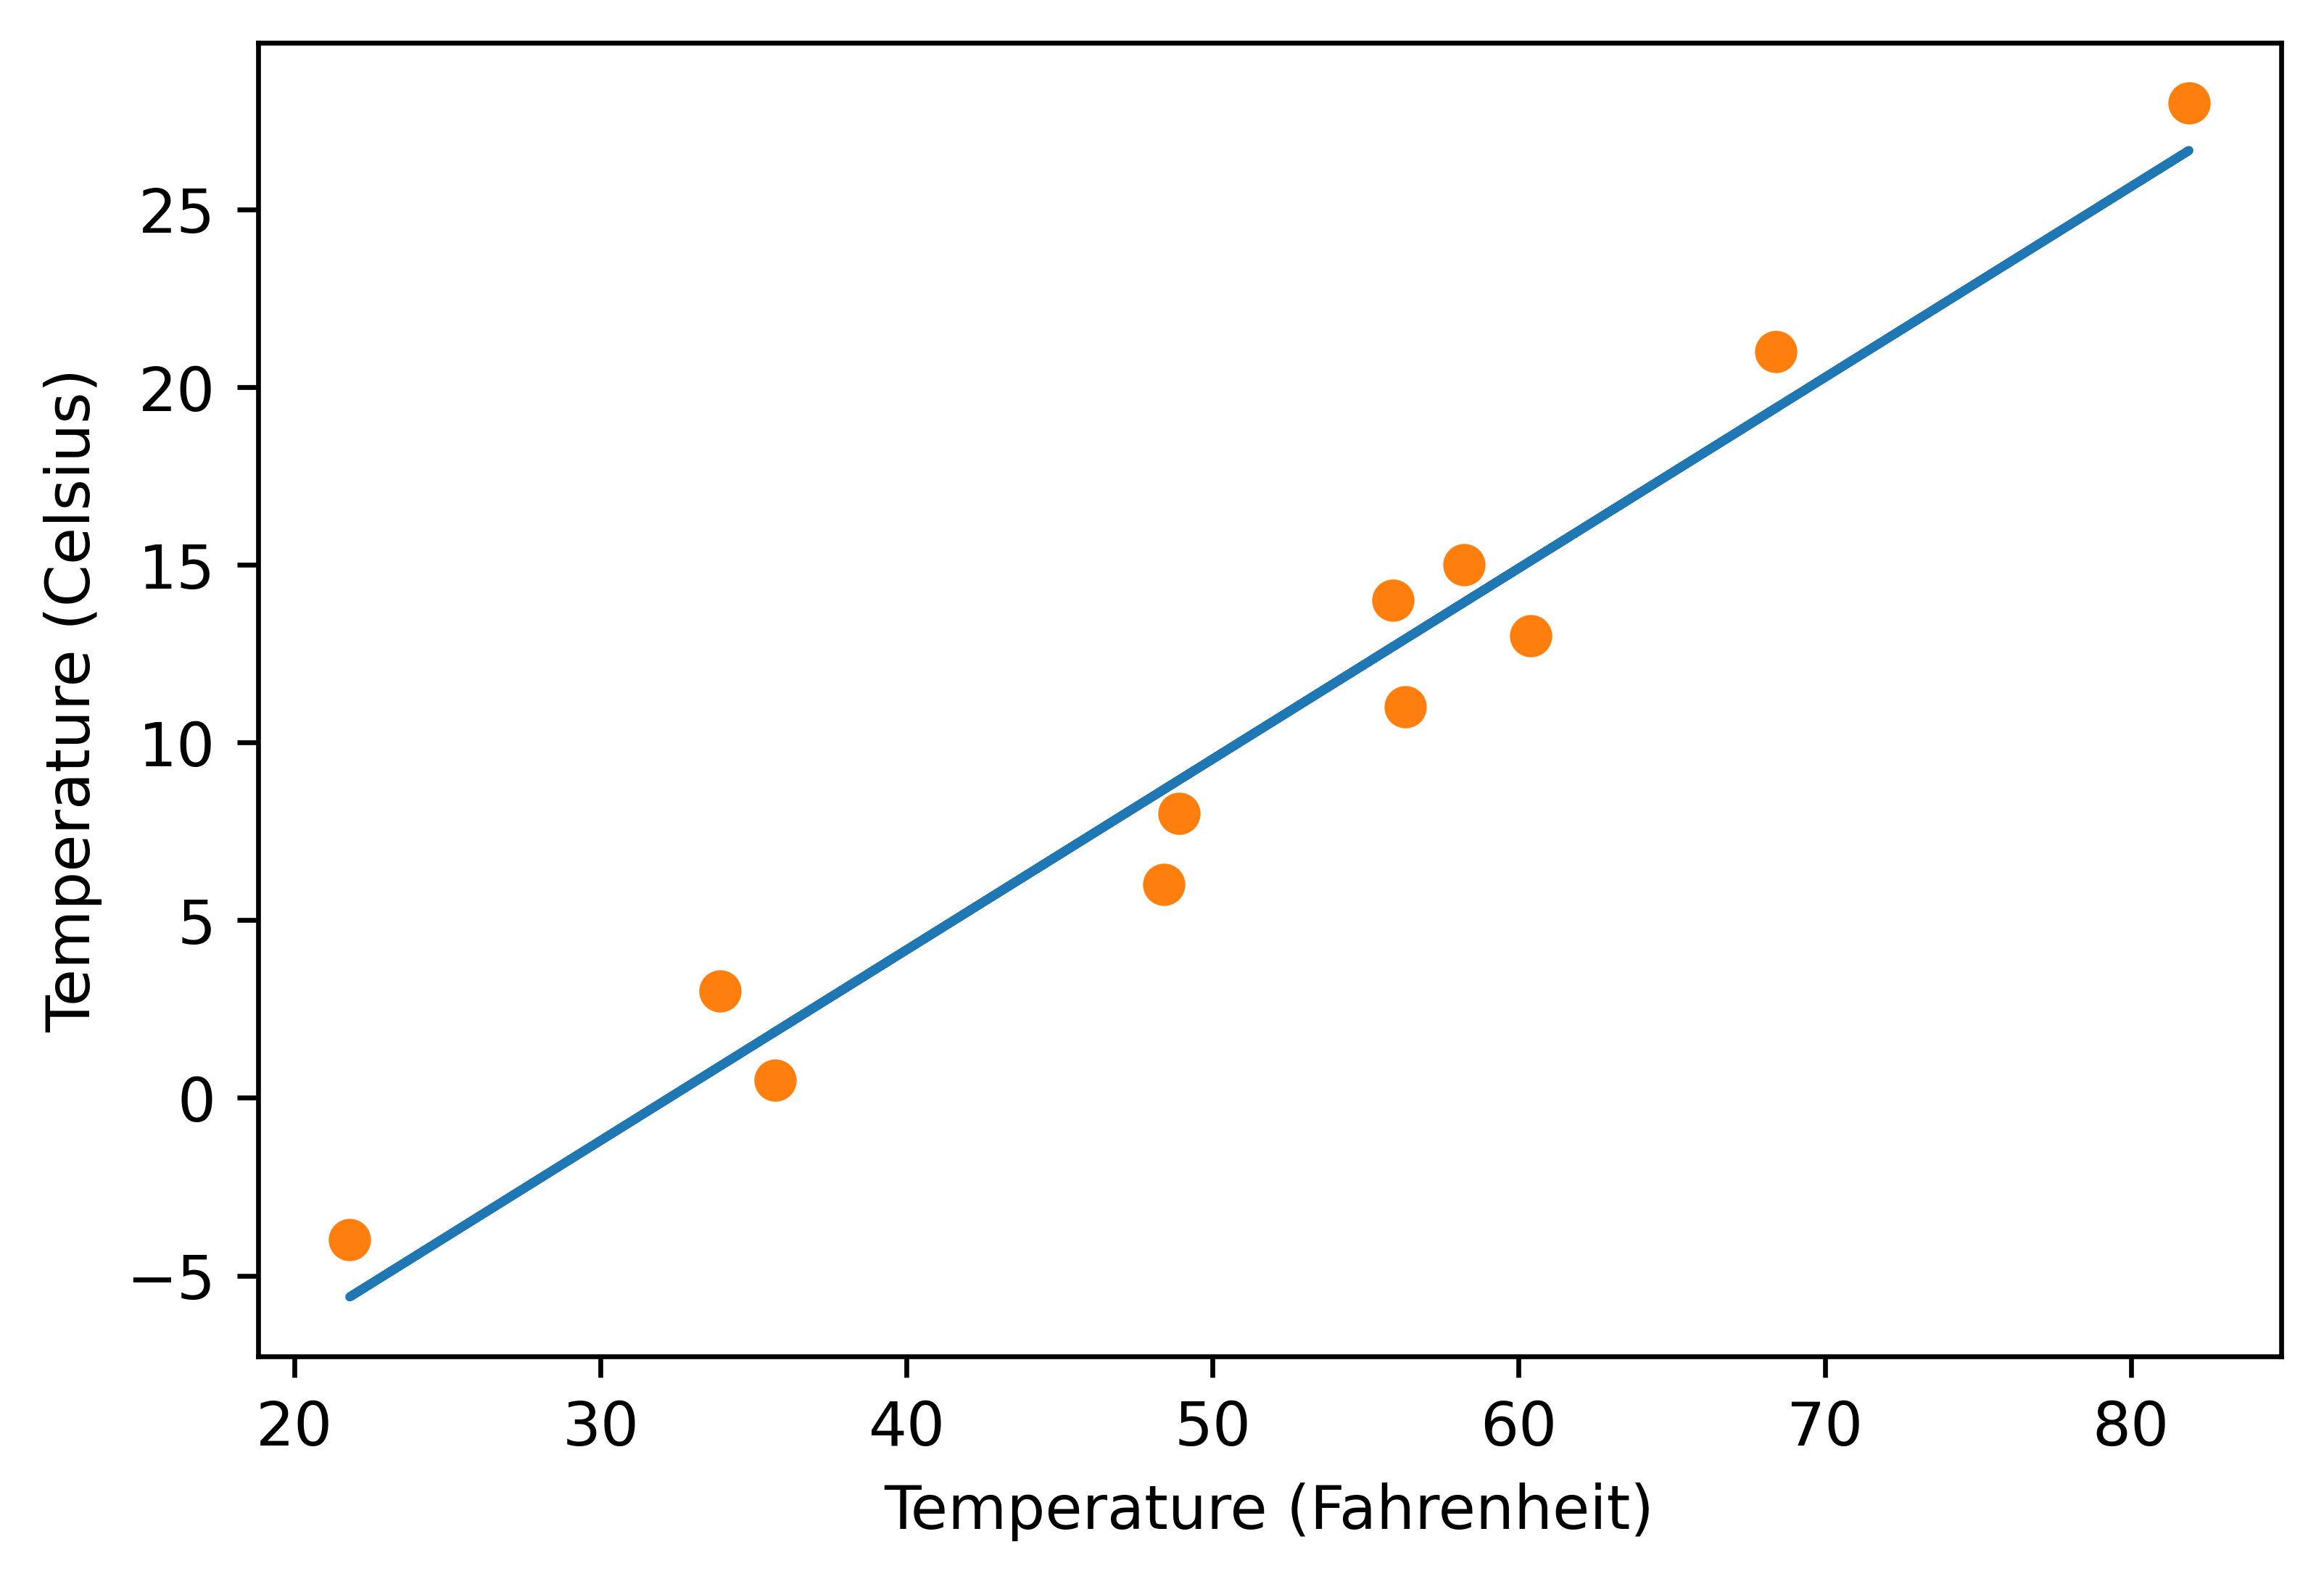

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi = 600)
plt
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Temperature (Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

We are using a Python trick called argument unpacking here: *params means to pass the elements of params as individual arguments.

In Python, this is usually done with lists or tuples, but we can also use argument unpacking with PyTorch tensors, which are split along the leading dimension.

So here, model(t_un, *params) is equivalent to model(t_un, params[0], params[1]).

## 5.5 PyTorch's autograd: Backpropagating all things

In our little adventure, we just saw a simple example of backpropagation.

We computed the gradient of composition of functions - the model and the loss - with respect to their innermost parameters (w and b) by propagating derivatives backward using the chain rule.

### 5.5.1. Computing the gradient automatically

This is when PyTorch tensors come to the rescue, with a PyTorch component called 'autograd'.

#### APPLYING AUTOGRAD

At this point, the best way to proceed is to rewrite our thermometer calibration code, this time using autograd, and see what happens.

In [29]:
def model(t_u, w, b):
    return w * t_u + b

In [30]:
def loss_fn(t_p, t_c):
    squred_diffs = (t_p - t_c)**2
    return squred_diffs.mean()

In [31]:
params = torch.tensor([1.0, 0.0], requires_grad = True)

#### USING THE GRAD ATTRIBUTE

Notice the 'requires_grad=True' argument to the tensor constructor?

That argument is telly PyTorch to track the entire family tree of tensor resulting from operations on params.

In other words, any tensor that will have params as an ancestor will have access to the chain of functions that were called to get from params to that tensor.

In case these functions are differentiable, the value of the derivative will be automatically populated as a grad attribute of the params tensor.

In general, all PyTorch tensors have an attribute named grad. Normally, it's 'None'

In [32]:
params.grad is None

True

In [33]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

At this point, the grad attribute of params contains the derivatives of the loss with respect to each element of params.

<img src = 'https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5fwdbwd.png'>

(The forward graph and backward graph of the model as computed with autograd)

#### ACCUMULATING GRAD FUNCTIONS

We could have any number of tensors with requires_grad set to True andn any composition of functions.

In this case, PyTorch would compute the derivatives of the loss throughout the chain of functions (the computation graph) and

accumulate their values in the grad attribute of those tensors (the leaf nodes of the graph).

Alert! We just wrote 'accumulate', not 'store'.

#### WARNING

Calling 'backward' will lead derivatives to accumulate at leaf nodes.

We need to zero the gradient explicitly after using it for parameter updates.

Let's repeat together: calling 'backward' will lead derivatives to accumulate at leaf nodes.

So i f backward was called earlier, the loss is evaluated again, backward is called again (as in any training loop),

and the graident at each leaf is acuumulated (that is, summed) on top of the one computed at the previous iteration, which leads to an incorrect value for the gradient.

In order to prevent this from occurring, we need to zero the gradient explicitly at each iteration. We can do this easily using the in-place zero_method:

In [35]:
if params.grad is not None:
    params.grad.zero_()

In [39]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
            
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [40]:
training_loop(n_epochs = 5000,
             learning_rate = 1e-2,
             params = torch.tensor([1.0, 0.0], requires_grad = True),
              t_u = t_un,
              t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

### 5.5.2 Optimizers a la carte

The torch module has an 'optim' submodule where we can find classes implementing different optimization algorithms.

In [41]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

<img src = 'https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5optimizer.png'>

Each optimizer exposes two methods: 'zero_grad' and step.zero_grad zeroes the 'grad' attribute of all the parameters passed to the optimizer upon construction.
    
'step' updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.

#### USING A GRADIENT DESSCENT OPTIMIZER

Let's create params and instantiate a gradient descent optimizer:

In [44]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

Here SGD stands for stochastic gradient descent.

In [45]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The value of 'params' is updated upon calling 'step' without us having to touch it ourselves!

What happens is that the optimizer looks into params.grad and updates params, subtracting 'learning_rate' times 'grad' from it, exactly as in our former hand-rolled code.

We forgot to zero out the gradients.

In [46]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

Let's update our training loop accordingly

In [48]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [53]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

#### TESTING OTHER OPTIMIZERS

In order to test more optimizers, all we have to do is instantiate a different optimizer, say 'Adam', instead of 'SGD'.

The rest of the code stays as it is. Pretty handy stuff.

We won't go into much detail about Adam; suffice to say that it is a more sophisticated optimizer in which the learning rate is set adaptively.

In [55]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr = learning_rate)

training_loop(n_epochs = 2000,
             optimizer = optimizer,
             params = params,
             t_u = t_u,
             t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

### 5.5.3 Training, validation, and overfitting

The first action we can take to combat overfitting is recognizing that it might happen.

We must take a few data points out of our dataset (the validation set) and only fit our model on the remaining data points (the training set), as shown in figure.

<img src = "https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5trainingvalidation.png">

#### EVALUATING THE TRAINING LOSS

The training loss will tell if our model can fit the training set at all - in other words,

if our model has enough capacity to process the relevant information in the data.

A deep neural network can potentially approximate complicated functions, provided that the number of neurons, and therefore parameters, is high enough.

The fewer the number of parameters, the simpler the shape of the function our network will be able to approximate.

So, rule 1:  if the training loss is not decreasing, chances are the model is too simple for the data.
    
#### GENERALIZING TO THE VALIDATION SET

If the loss evaluated in the validation set doesn't decrease along with the training set, it means our model is improving its fit of the samples it is seeing during training,

but it is not generalizing to samples outside this precise set.

Rule2: if the training loss and the validation loss diverge, we're overfitting.
    
<img src = "https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5overfitting.png">

(Rather extreme example of overfitting)

#### SPLITTING A DATASET

In [100]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([7, 6, 8, 9, 3, 2, 5, 0, 1]), tensor([ 4, 10]))

In [101]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [102]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                 f" Validation loss {val_loss.item():.4f}")
            
    return params

In [108]:
parasm = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-2
optimzier = optim.SGD([params], lr = learning_rate)

training_loop(n_epochs = 3000,
             optimizer = optimizer,
             params = params,
             train_t_u = train_t_un,
             val_t_u = val_t_un,
             train_t_c = train_t_c,
             val_t_c = val_t_c)

Epoch 1, Training loss 2.8758, Validation loss 3.2475
Epoch 2, Training loss 2.8758, Validation loss 3.2475
Epoch 3, Training loss 2.8758, Validation loss 3.2474
Epoch 500, Training loss 2.8756, Validation loss 3.2368
Epoch 1000, Training loss 2.8756, Validation loss 3.2327
Epoch 1500, Training loss 2.8756, Validation loss 3.2312
Epoch 2000, Training loss 2.8756, Validation loss 3.2307
Epoch 2500, Training loss 2.8756, Validation loss 3.2305
Epoch 3000, Training loss 2.8756, Validation loss 3.2305


tensor([  5.2993, -16.9301], requires_grad=True)

Here we are not being entirely fair to our model.

The validation set is really small, so the validation loss will only be meaningful up to a point.

<img src = "https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5trainvalloss.png">

(case C is ideal, while D is acceptable. In case A, the model isn't learning at all; and in case B, we see overfitting.)

### 5.5.4 Autograd nits and switching it off

<img src = 'https://drek4537l1klr.cloudfront.net/stevens2/v-10/Figures/p1ch5twolosses.png'>

(Diagram showing how gradients propagate through a graph with two losses when .backward is called on one of them)

## 5.6 Conclusion

We spent the chapter describing the mechanism with which a model can be optimized to fit data.

In chapter 6 we'll finally get to the main course: using a neural network to fit our data.

We'll work on solving the same thermometer problem, but with the more powerful tools provided by the 'torch.nn' module.